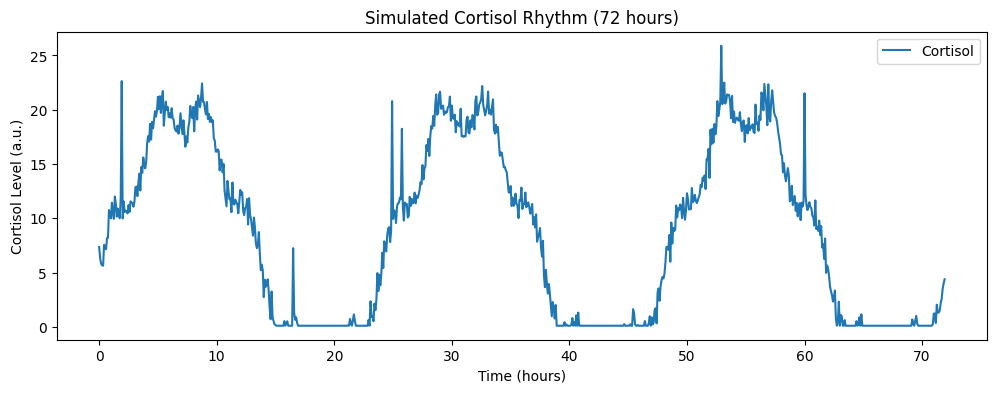

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

# Simulate 72 hours (3 days) at 5-minute intervals
time_hours = np.arange(0, 72, 5/60)

# -----------------------------
# Physiologically realistic cortisol model
# -----------------------------

# Circadian component (morning peak ~7 AM)
circadian = 12 * np.cos((2 * np.pi / 24) * (time_hours - 7))

# Ultradian pulses (~4-hour rhythm)
ultradian = 2 * np.sin((2 * np.pi / 4) * time_hours)

# Baseline cortisol level
baseline = 8

# Combine baseline + rhythms
cortisol = baseline + circadian + ultradian

# -----------------------------
# Add random physiological stress spikes
# -----------------------------
stress_spikes = np.zeros_like(time_hours)
stress_times = np.random.choice(len(time_hours), 6, replace=False)
stress_spikes[stress_times] = np.random.uniform(5, 12, size=6)

# Add stress + biological noise
cortisol = cortisol + stress_spikes + np.random.normal(0, 0.8, len(time_hours))

# Prevent negative physiological values
cortisol = np.clip(cortisol, 0.1, None)

# -----------------------------
# Simulate wearable signals
# -----------------------------
heart_rate = 65 + 8*np.sin((2*np.pi/24)*time_hours + 0.5) + stress_spikes*2
temperature = 36.5 + 0.3*np.sin((2*np.pi/24)*time_hours - 1)

# -----------------------------
# Create DataFrame
# -----------------------------
df = pd.DataFrame({
    "time_hours": time_hours,
    "cortisol": cortisol,
    "heart_rate": heart_rate,
    "temperature": temperature
})

# -----------------------------
# Plot cortisol
# -----------------------------
plt.figure(figsize=(12,4))
plt.plot(time_hours, cortisol, label="Cortisol")
plt.xlabel("Time (hours)")
plt.ylabel("Cortisol Level (a.u.)")
plt.title("Simulated Cortisol Rhythm (72 hours)")
plt.legend()
plt.show()

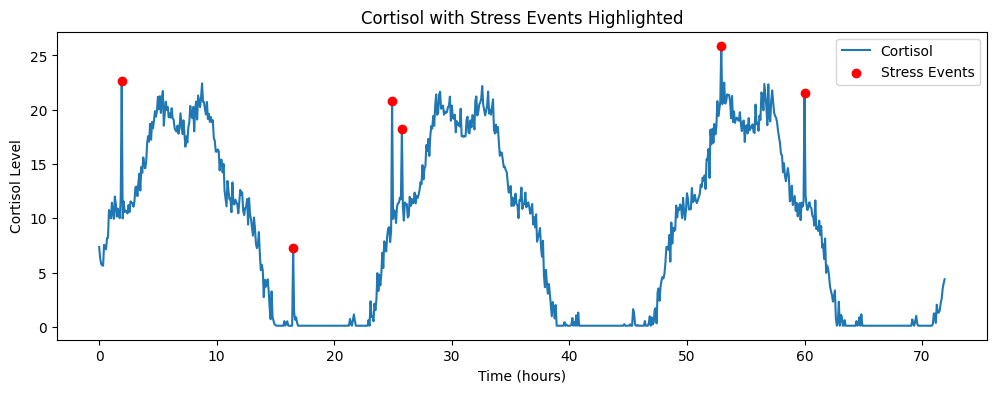

In [6]:
plt.figure(figsize=(12,4))
plt.plot(time_hours, cortisol, label="Cortisol")
plt.scatter(time_hours[stress_times], cortisol[stress_times], 
            color='red', label="Stress Events", zorder=5)

plt.xlabel("Time (hours)")
plt.ylabel("Cortisol Level")
plt.title("Cortisol with Stress Events Highlighted")
plt.legend()
plt.show()

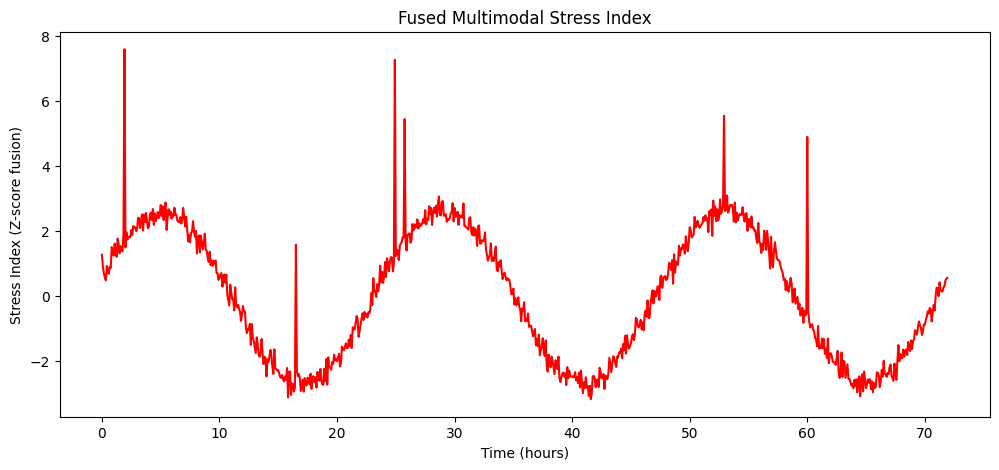

In [6]:
# Simple multimodal fusion score (stress index)

df["stress_index"] = (
    (df["cortisol"] - df["cortisol"].mean()) / df["cortisol"].std() +
    (df["heart_rate"] - df["heart_rate"].mean()) / df["heart_rate"].std()
)

plt.figure(figsize=(12,5))
plt.plot(df["time_hours"], df["stress_index"], color="red")
plt.title("Fused Multimodal Stress Index")
plt.xlabel("Time (hours)")
plt.ylabel("Stress Index (Z-score fusion)")
plt.show()

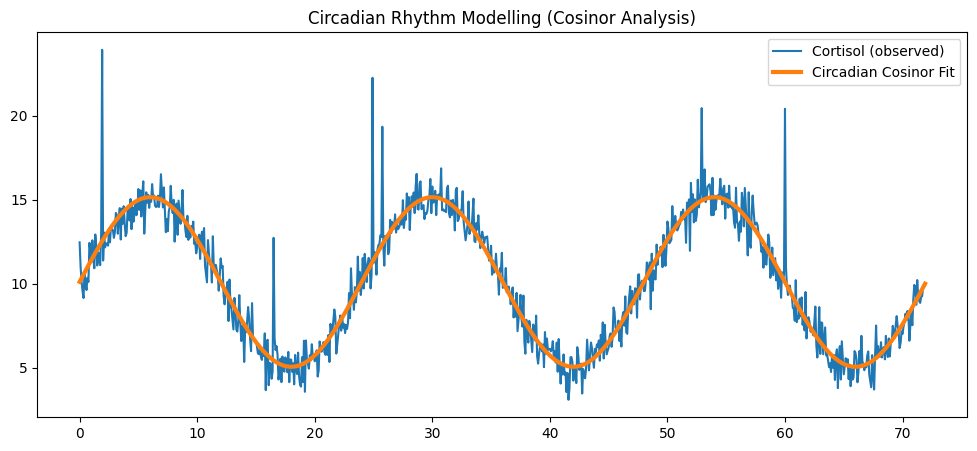

In [7]:
import numpy as np
from scipy.optimize import curve_fit

# Cosinor model
def cosinor(t, M, A, phi):
    return M + A * np.cos((2 * np.pi / 24) * t + phi)

params, _ = curve_fit(cosinor, df["time_hours"], df["cortisol"])

df["cosinor_fit"] = cosinor(df["time_hours"], *params)

plt.figure(figsize=(12,5))
plt.plot(df["time_hours"], df["cortisol"], label="Cortisol (observed)")
plt.plot(df["time_hours"], df["cosinor_fit"], label="Circadian Cosinor Fit", linewidth=3)
plt.legend()
plt.title("Circadian Rhythm Modelling (Cosinor Analysis)")
plt.show()

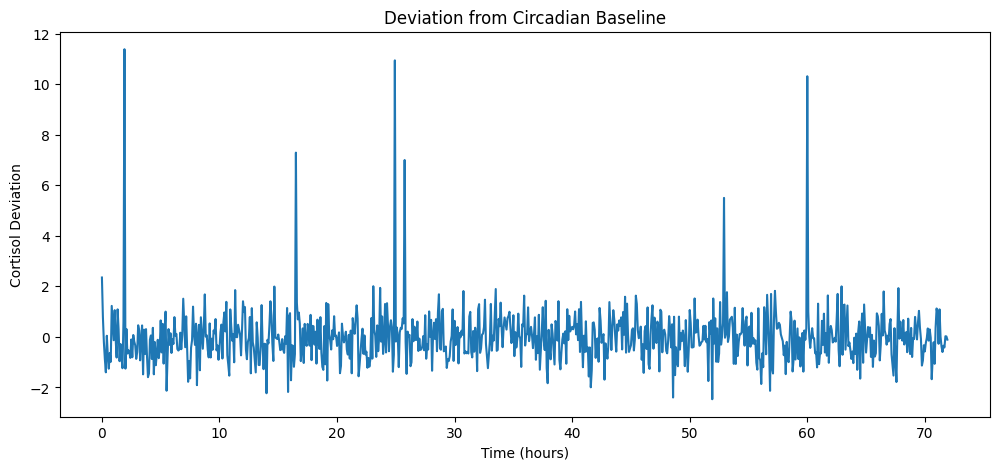

In [8]:
df["rhythm_deviation"] = df["cortisol"] - df["cosinor_fit"]

plt.figure(figsize=(12,5))
plt.plot(df["time_hours"], df["rhythm_deviation"])
plt.title("Deviation from Circadian Baseline")
plt.xlabel("Time (hours)")
plt.ylabel("Cortisol Deviation")
plt.show()

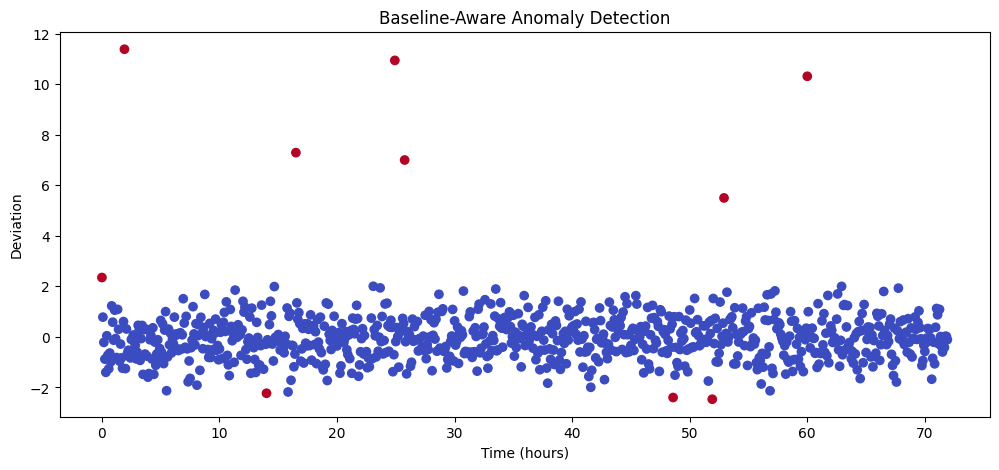

In [9]:
threshold = 2 * df["rhythm_deviation"].std()
df["baseline_anomaly"] = np.abs(df["rhythm_deviation"]) > threshold

plt.figure(figsize=(12,5))
plt.scatter(df["time_hours"], df["rhythm_deviation"],
            c=df["baseline_anomaly"], cmap="coolwarm")
plt.title("Baseline-Aware Anomaly Detection")
plt.xlabel("Time (hours)")
plt.ylabel("Deviation")
plt.show()